In [ ]:
''' Datsest can be found here: https://www.kaggle.com/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving/data'''

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import sklearn as sk
import pandas as pd
import torch
import random 
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
import scipy.cluster.hierarchy as sch
from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.models import load_model
from keras import backend as K
import joblib

In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
torch.cuda.set_device(0)

1
NVIDIA GeForce RTX 2060


In [4]:
# Initialise directories and labels
patht = './dataset/training_set'
pathv = './dataset/validation_set'
categories = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']

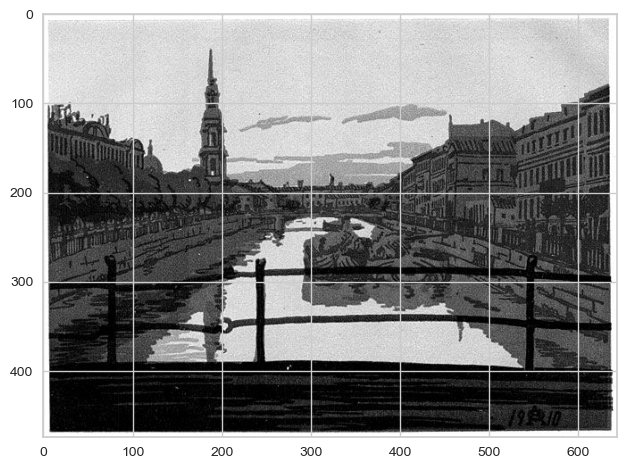

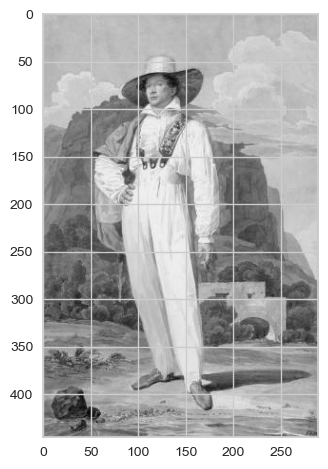

In [5]:
# label dataset and load as grayscale
for category in categories:
    path = os.path.join(patht, category)
    for img in os.listdir(path):
        img_array_t = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array_t, cmap='gray')
        plt.show()
        break
    break

for category in categories:
    path = os.path.join(pathv, category)
    for img in os.listdir(path):
        img_array_v = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array_v, cmap='gray')
        plt.show()
        break
    break

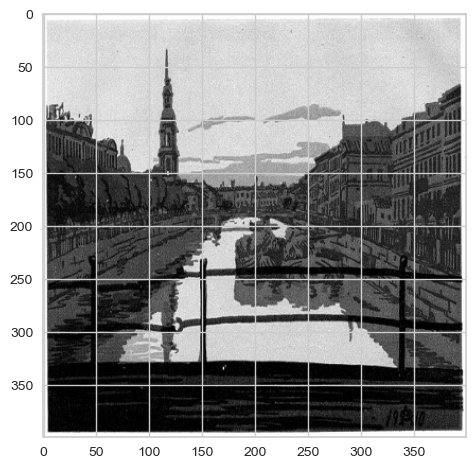

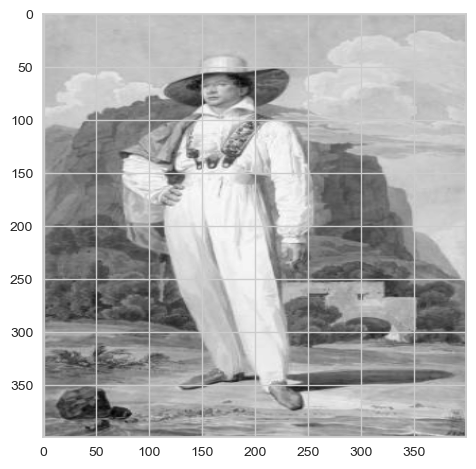

In [6]:
#rescales all images as the same size
img_size = 400

new_array_t = cv2.resize(img_array_t, (img_size,img_size))
new_array_v = cv2.resize(img_array_v, (img_size,img_size))
plt.imshow(new_array_t, cmap='gray')
plt.show()
plt.imshow(new_array_v, cmap='gray')
plt.show()

In [7]:
training_data = []
validation_data = []

def create_training_data():
    for category in categories:
        path = os.path.join(patht, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array_t = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) #read everything in grayscale
                new_array_t = cv2.resize(img_array_t, (img_size,img_size))
                training_data.append([new_array_t, class_num])
            except Exception as e: #if it won't load, skip it
                pass

def create_validation_data():
    for category in categories:
        path = os.path.join(pathv, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array_v = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) #read everything in grayscale
                new_array_v = cv2.resize(img_array_v, (img_size,img_size))
                validation_data.append([new_array_v, class_num])
            except Exception as e: #if it won't load, skip it
                pass
            
create_training_data()
create_validation_data()

In [8]:
random.shuffle(training_data)
random.shuffle(validation_data)
print(len(training_data))
print(len(validation_data))

7721
856


In [9]:
#feature extraction
train_x = []
train_y = []
val_x = []
val_y = []

for features, label in training_data:
    train_x.append(features)
    train_y.append(label)

for features, label in validation_data:
    val_x.append(features)
    val_y.append(label)
    
train_x = np.array(train_x).reshape(-1, img_size, img_size, 1)
train_y = np.array(train_y)
val_x = np.array(val_x).reshape(-1, img_size, img_size, 1)
val_y = np.array(train_y)

train_x = train_x/255
val_x = val_x/255

In [10]:
train_x.shape

(7721, 400, 400, 1)

In [11]:
val_x.shape

(856, 400, 400, 1)

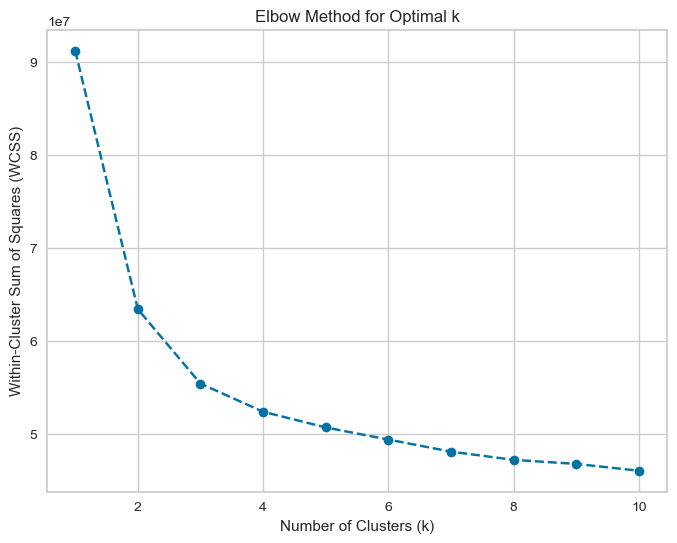

In [22]:
train_x_flat = train_x.reshape(train_x.shape[0], -1)
val_x_flat = val_x.reshape(val_x.shape[0], -1)

wcss_values = []

# Try different values of k (Elbow method)
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state= None)
    model.fit(train_x_flat)
    wcss_values.append(model.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss_values, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

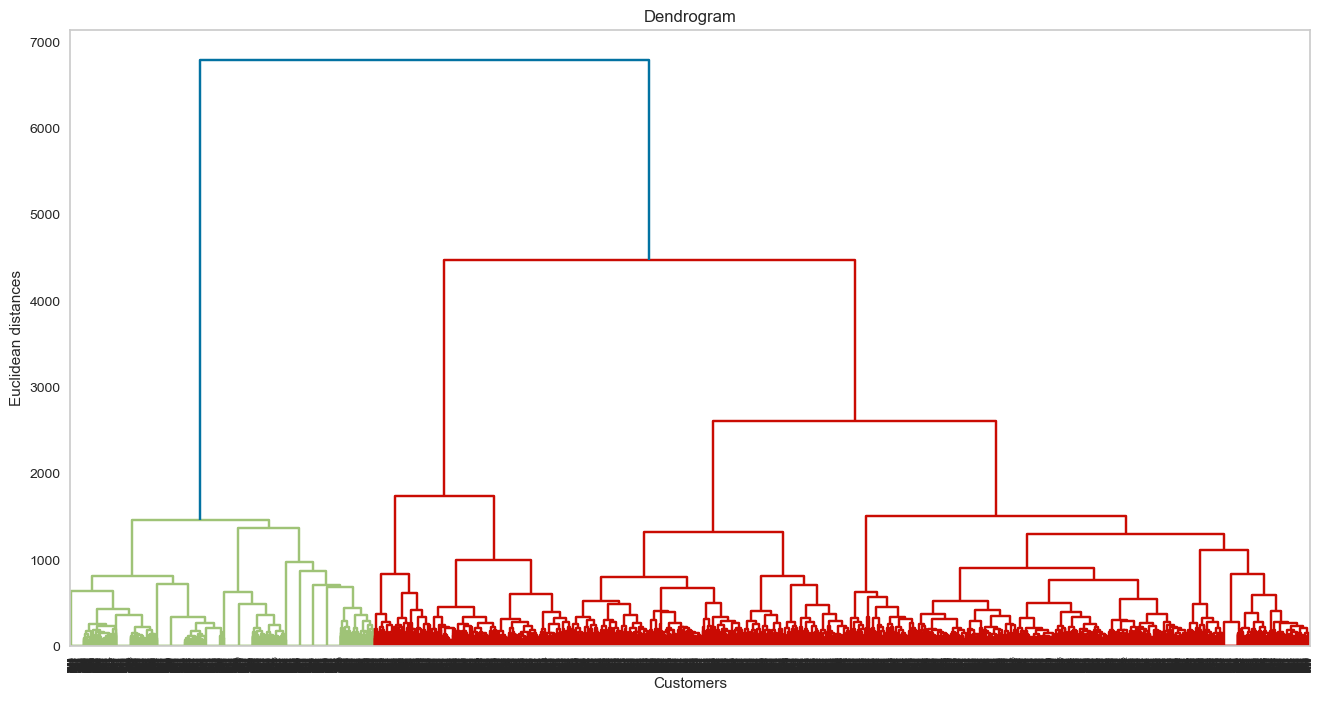

In [12]:
train_x_flat = train_x.reshape(train_x.shape[0], -1)
val_x_flat = val_x.reshape(val_x.shape[0], -1)

plt.figure(1, figsize = (16 ,8))
plt.grid(False)
dendrogram = sch.dendrogram(sch.linkage(train_x_flat, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Clusters')
plt.ylabel('Euclidean distances')
plt.show()

In [12]:
#Evaluate model using validation set and Silhouette Score
# Flatten sets and fit to KMeans model
def Kmeans():
    train_x_flat = train_x.reshape(train_x.shape[0], -1)
    val_x_flat = val_x.reshape(val_x.shape[0], -1)
    
    n_clusters = 2
    model = KMeans(n_clusters=n_clusters, random_state = None)
    model.fit(train_x_flat)
    cluster_labels = model.labels_
    val_clusters = model.predict(val_x_flat)
    silhouette_avg = silhouette_score(val_x_flat, val_clusters)
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    
    # Visualize the clustered images (optional)
    for cluster_num in range(n_clusters):
        cluster_indices = np.where(val_clusters == cluster_num)[0]
        sample_indices = cluster_indices[:5]  # Display the first 5 samples from each cluster
        plt.figure(figsize=(10, 2))
        for i, idx in enumerate(sample_indices):
            plt.subplot(1, 5, i + 1)
            plt.imshow(val_x[idx].reshape(img_size, img_size), cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Cluster {cluster_num} (Centroid)")
        plt.show()

    model_filename = 'kmeans.h5'
    joblib.dump(model, model_filename)
    
    print(f"Model saved as {model_filename}")

In [13]:
def Agglomerative():
    train_x_flat = train_x.reshape(train_x.shape[0], -1)
    val_x_flat = val_x.reshape(val_x.shape[0], -1)
    
    n_clusters = 3

    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    model.fit(train_x_flat)
    
    val_clusters = model.fit_predict(val_x_flat)
    silhouette_avg = silhouette_score(val_x_flat, val_clusters)
    print(f"Silhouette Score: {silhouette_avg:.4f}")
    
    for cluster_num in range(n_clusters):
        cluster_indices = np.where(val_clusters == cluster_num)[0]
        sample_indices = cluster_indices[:5]  # Display the first 5 samples from each cluster
        plt.figure(figsize=(10, 2))
        for i, idx in enumerate(sample_indices):
            plt.subplot(1, 5, i + 1)
            plt.imshow(val_x[idx].reshape(img_size, img_size), cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Cluster {cluster_num} (Centroid)")
        plt.show()

    model_filename = 'agg.h5'
    joblib.dump(model, model_filename)
    
    print(f"Model saved as {model_filename}")

In [14]:
def dbscan(data):
    eps = 0.3 
    min_samples = 10  
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    
    cluster_labels = dbscan_model.labels_
    
    unique_clusters = set(cluster_labels)
    print("Estimated number of clusters:", len(unique_clusters))
    model_filename = 'dbscan.h5'
    joblib.dump(model, model_filename)
    
    print(f"Model saved as {model_filename}")

In [24]:
def CNN(x, y, xv, yv):
    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
    model = Sequential()
    model.add(Conv2D(64, (3,3), input_shape = train_x.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    #loss=sparse_categorical_crossentropy
    
    model.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy', f1_m, precision_m, recall_m])
    
    model.fit(x, y, batch_size=40, epochs=15, validation_split=0.1)

    loss, accuracy, f1_score, precision, recall = model.evaluate(xv, yv, verbose=0)
    
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    
    model.save('CNN.h5')
    model.save('CNN.keras')
    model.save_weights('CNN_weights.h5')

Silhouette Score: 0.2415


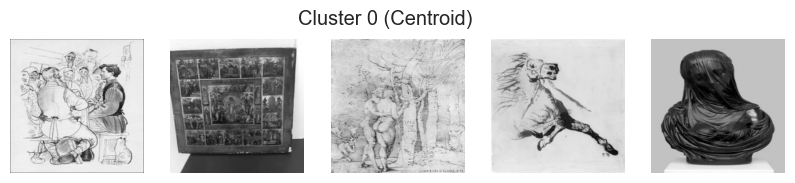

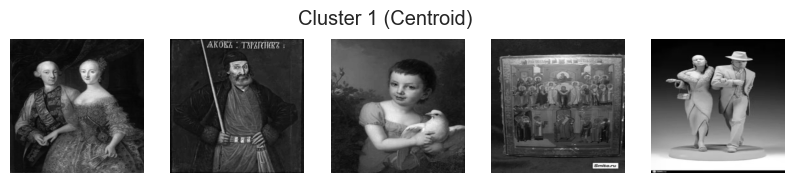

Model saved as kmeans.h5


In [25]:
Kmeans()

Silhouette Score: 0.1713


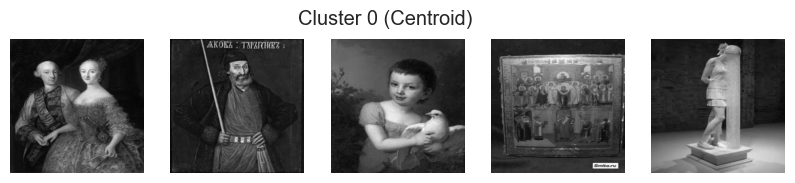

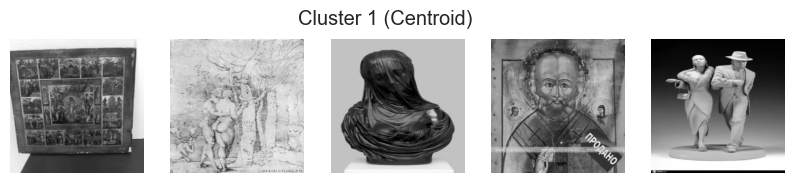

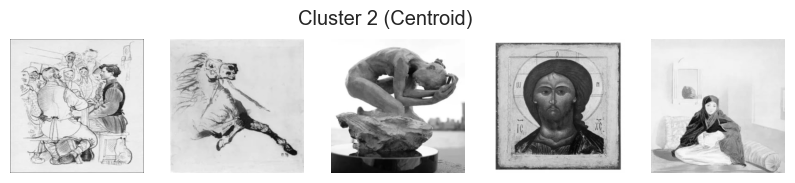

Model saved as agg.h5


In [26]:
Agglomerative()

In [ ]:
dbscan(training_data)

In [25]:
CNN(train_x, train_y, val_x, val_y)

NameError: name 'f1_score_m' is not defined

In [20]:
import gradio as gr

def process_image(image, model_type):
    """Function to process the image based on the selected model type.
       Replace this with your actual image processing logic."""
    
    if model_type == "Classification":
        # Classification model logic here
        output_text = keras.load_model('CNN.keras')
    elif model_type == "Captioning":
        # Image captioning model logic here
        output_text = "Generated a caption for the image."
    else:
        output_text = "Unsupported model type."

    return output_text


with gr.Blocks() as interface:
    gr.Markdown("<h1>Image Processing Interface</h1>")

    with gr.Row():
        image_input = gr.Image(label="Upload Image")
        model_type = gr.Dropdown(["Classification", "Captioning"], label="Model Type")

    output_text = gr.Textbox(label="Output")

    image_input.change(process_image, inputs=[image_input, model_type], outputs=output_text)

interface.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.
